OBJECTIVE -
Explore and build time series forecasting models for measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

Notes:

1. (globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

date: Date in format dd/mm/yyyy
time: time in format hh:mm:ss
globalactivepower: household global minute-averaged active power (in kilowatt)
globalreactivepower: household global minute-averaged reactive power (in kilowatt)
voltage: minute-averaged voltage (in volt)
global_intensity: household global minute-averaged current intensity (in ampere)
submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.<br>

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Time Series Libraries
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [7]:
# load the dataset from txt
df = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
                 infer_datetime_format=True, parse_dates={'datetime': [0, 1]}, index_col=['datetime'])

# view size and priview first 5 rows in the dataset
print(df.shape)
df.head()

(2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [13]:
# Ascertain missing values
df.isnull().values.sum()

25979

In [14]:
# Fill missing data by using linear forward interpolation
df = df.interpolate(method='linear', limit_direction='forward')
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [21]:
# create a copy without altering df
df_copy = df.copy()

In [22]:
# re-ascertain for null values
df_copy.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [23]:
# convert columns to float types
cols = df_copy.columns
df_copy[cols] = df_copy[cols].apply(pd.to_numeric, errors='coerce')

In [25]:
# Calculate and Add active energy consumed every minutes
df_copy['Energy_Consumed_Per_Min'] = ((df_copy['Global_active_power'] * 1000)/60 -
                                      df_copy['Sub_metering_1'] - df_copy['Sub_metering_2'] - df_copy['Sub_metering_3'])
df_copy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumed_Per_Min
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [26]:
# Create Time Series with Global active power
df_copy1 = df_copy.drop(columns=['Energy_Consumed_Per_Min', 'Global_reactive_power', 'Voltage',
                                 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1)

In [30]:
# Filling missing data by linear forward interpolation
df_copy1 = df_copy1.interpolate(method='linear', limit_direction='forward')
df_copy1.isnull().sum()

Global_active_power        0
Global_reactive_power      0
Voltage                    0
Global_intensity           0
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
Energy_Consumed_Per_Min    0
dtype: int64

In [33]:
# create  and preview  time series for Global active power per minutes
df2 = df_copy1[['Global_active_power']]
df2.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


Text(0, 0.5, 'Global Active Power')

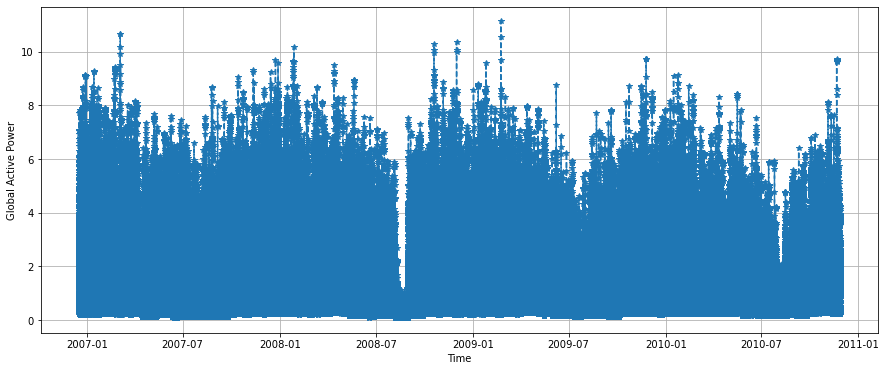

In [45]:
# preview Global_active_power plot
plt.figure(figsize=(15, 6))
plt.plot(df2.index, df2.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Time')
plt.ylabel('Global Active Power')

In [36]:
# Downsample Global Active Power from minutes to daily data points
df_daily = df2.resample('D').mean()

Text(0, 0.5, 'Global Active Power')

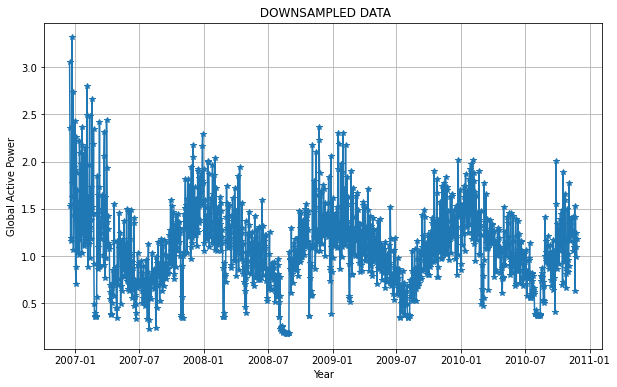

In [48]:
# preview downsampling 
plt.figure(figsize=(10, 6))
plt.plot(df_daily, marker='*')
plt.grid()
plt.title(' DOWNSAMPLED DATA')
plt.xlabel('Year')
plt.ylabel('Global Active Power')

Text(0, 0.5, 'Global active power')

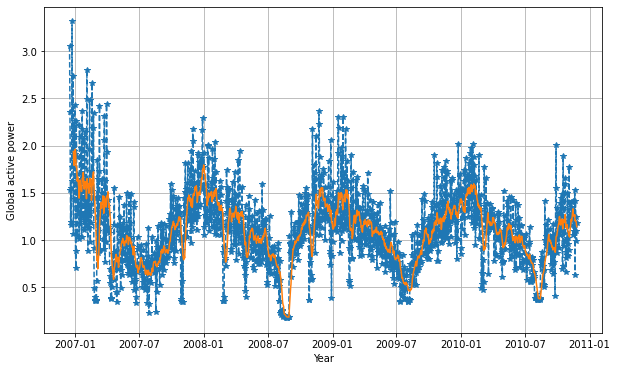

In [39]:
# Adding a Moving Average Smoothing
df_MA = df_daily.copy()
MA = df_MA[ 'Global_active_power' ].rolling( 12 ).mean()

# Preview Moving Average plot
plt.figure(figsize=(10, 6))
plt.plot(df_MA.index, df_MA.Global_active_power, '--', marker='*', )
plt.plot(MA)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global active power')

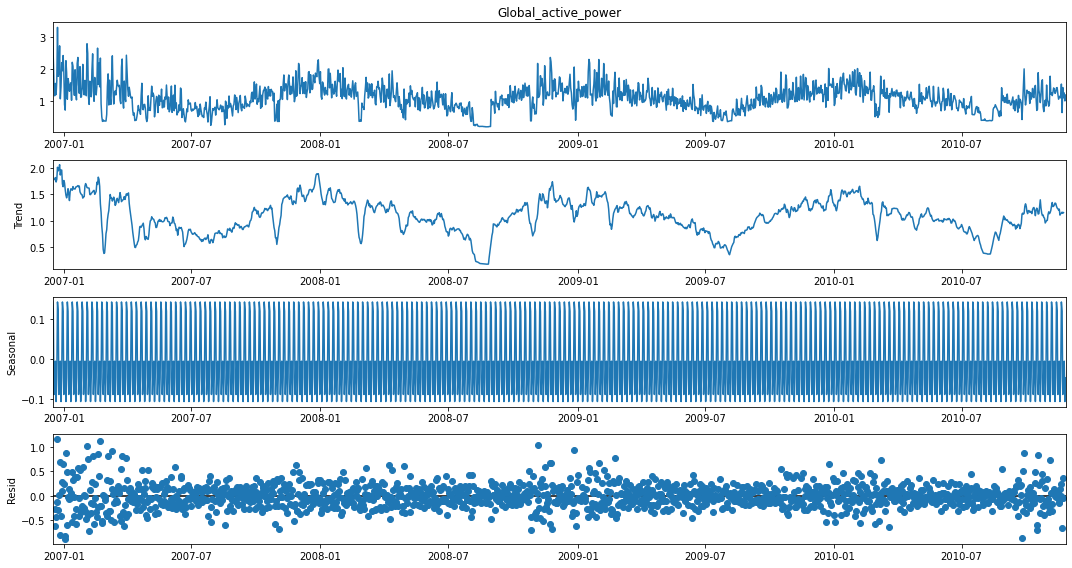

In [50]:
# plot seasonal_decompose statistical summary
rcParams[ 'figure.figsize' ] = 15 , 8
decompose_series = sm.tsa.seasonal_decompose(df_daily[ 'Global_active_power' ], model= 'additive' )
decompose_series.plot()
plt.show()

## CHECK FOR STATIONARITY

In [52]:
# Using Auto - Dick Fuller to determine the trend and seasonality variations.

adf_result = adfuller(df_daily['Global_active_power'])
print(f'ADF Statistic: {adf_result[ 0 ]} ')
print(f'p-value: {adf_result[ 1 ]} ')
print(f'No. of lags used: {adf_result[ 2 ]} ')
print(f'No. of observations used : {adf_result[ 3 ]} ')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f' {k} : {v} ')

ADF Statistic: -3.686733825681114 
p-value: 0.0043036718780010245 
No. of lags used: 22 
No. of observations used : 1419 
Critical Values:
 1% : -3.434966750462565 
 5% : -2.8635789736973725 
 10% : -2.5678555388041384 


## CHECK FOR APPRIOPRATE MODEL

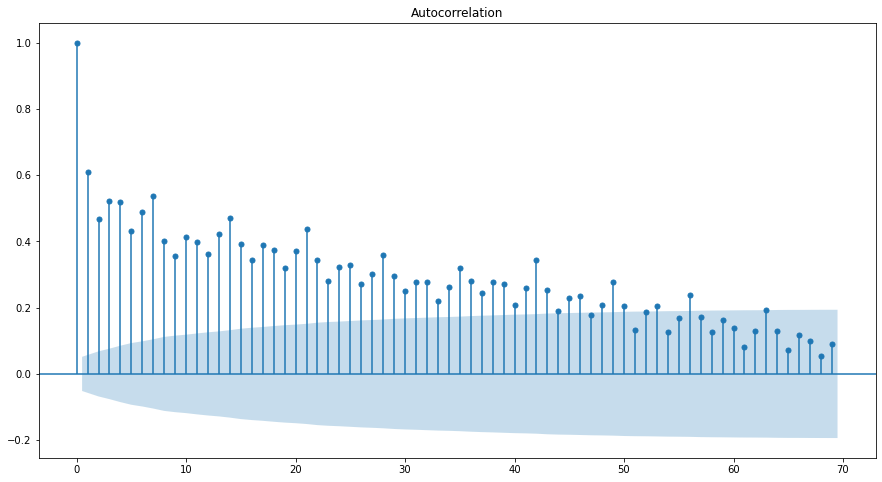

In [53]:
#ACF Test 
plot_acf(df_daily, lags = range( 0 , 70 ))
plt.show()

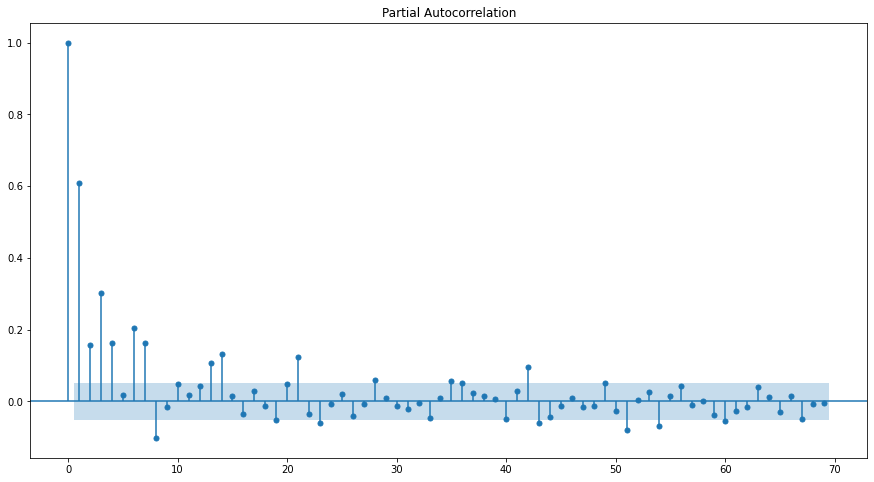

In [54]:
#PACF Test

plot_pacf(df_daily, lags = range( 0 , 70 ))
plt.show()

## TRAIN MODELS

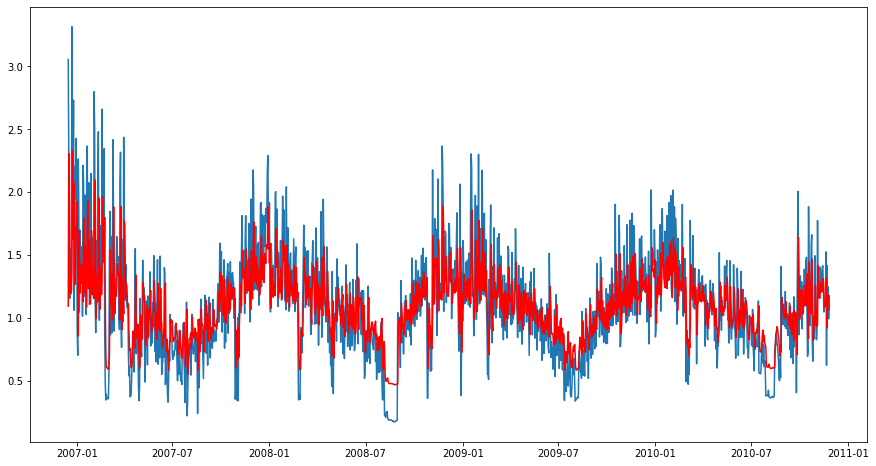

In [55]:
# USING AR MODEL
AR_model = ARIMA(df_daily, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_daily)
plt.plot(AR_model_results.fittedvalues, color='red')
plt.show()

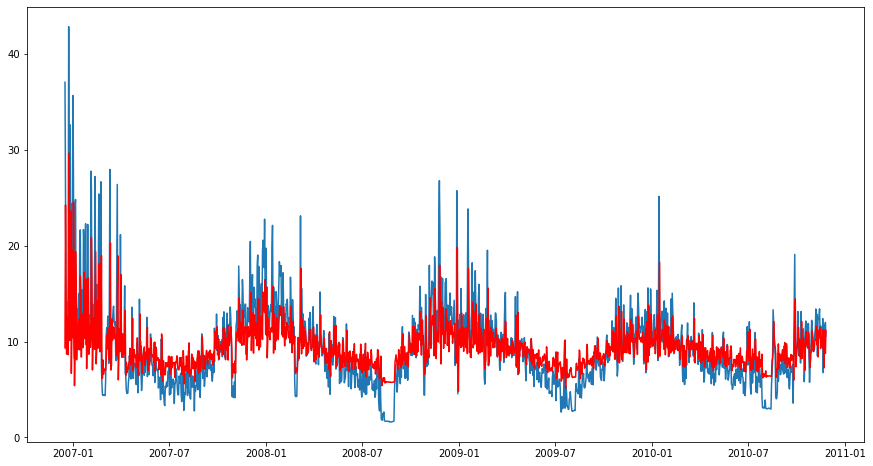

In [24]:
# USING MA MODEL
AR_model = ARIMA(df_daily, order=(0,0,2))
AR_model_results = AR_model.fit()
plt.plot(df_daily)
plt.plot(AR_model_results.fittedvalues, color='red')
plt.show()

In [25]:
# restructure data to fbprophet format
df1=df_daily.copy()
df1 = df1.reset_index()
df1 = df1.rename(columns={ "datetime" : "ds" , "Energy_Consumed_Per_Min" : "y" })
df1.head()

,ds,y
0,2006-12-16,37.073064
1,2006-12-17,25.657407
2,2006-12-18,13.214190
3,2006-12-19,9.119375
4,2006-12-20,14.156111


In [26]:
# train model using fbprophet
model = Prophet()
model.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


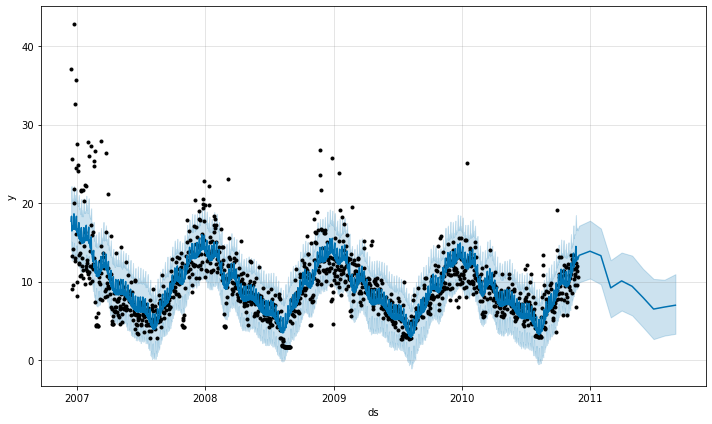

In [27]:
#predict for the next 10 months
future = model.make_future_dataframe(periods= 10 , freq= 'M' )
forecast = model.predict(future)
forecast.head()
forecast[[ 'ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper' ]]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
model.plot(forecast)
plt.show()

In [180]:
df2 = df_copy1[['Global_active_power']]

Text(0, 0.5, 'Global active power')

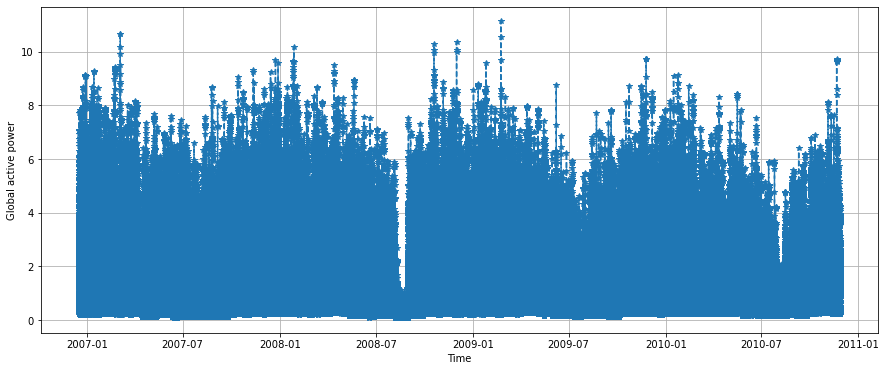

In [210]:
plt.figure(figsize=(15, 6))
plt.plot(df_copy.index, df2.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Time')
plt.ylabel('Global active power')

# Get training and testing sets

In [196]:
# Downsample to daily data points
df_daily1 = df2.resample('D').mean()
df_daily1 = df_daily1.reset_index()
df_daily1 = df_daily1.rename(columns={ "datetime" : "ds" , "Global_active_power" : "y" })
df_daily1

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658
...,...,...
1437,2010-11-22,1.417733
1438,2010-11-23,1.095511
1439,2010-11-24,1.247394
1440,2010-11-25,0.993864


In [197]:
train_end = 1442 - 365

train_data = df_daily1.iloc[:train_end]
test_data = df_daily1.iloc[train_end:]

In [198]:
# # Filling missing data by linear forward interpolation
# df_copy1 = df_copy.interpolate(method='linear', limit_direction='forward')
# df_copy1.isnull().sum()

# Fit the PROPHET Model

In [199]:
# define model
model = Prophet()

In [200]:
#fit the model
model_fit = model.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [201]:
#summary of the model

## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [202]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [203]:
#get the predictions and residuals
predictions = model_fit.predict(test_data)
residuals = test_data - predictions

In [204]:
predictions = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [205]:
metric = predictions.set_index('ds')[['yhat']].join(test_data.set_index('ds').y).reset_index()

In [206]:
sqrt(mean_absolute_error(metric.y, metric.yhat))

0.4485097987725939

In [207]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [208]:
mean_absolute_percentage_error(metric.y, metric.yhat)

21.421305377055674

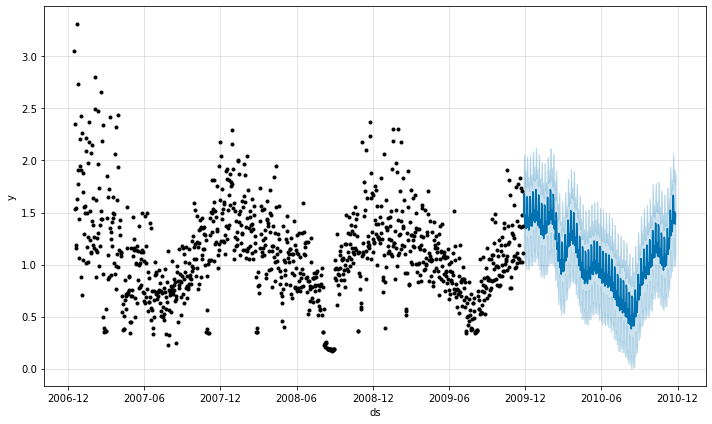

In [209]:
model.plot(predictions)
plt.show()